<a href="https://colab.research.google.com/github/mot1122/NLP_100_knock/blob/main/chap9_rnn_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第9章: RNN, CNN
### 80 ID番号への変換
>>
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-01-28 15:42:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  32.3MB/s    in 0.9s    

2022-01-28 15:42:21 (32.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
!sed -e "s/"\""/'/g" ./newsCorpora.csv > ./newsCorpora_re.csv

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
df=pd.read_csv("./newsCorpora.csv",header=None,sep="\t",names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

In [5]:
df=df.loc[df["PUBLISHER"].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']),["TITLE","CATEGORY"]]

In [6]:
train,valid_test=train_test_split(df,test_size=0.2,shuffle=True,stratify=df["CATEGORY"],random_state=123)
valid,test=train_test_split(valid_test,test_size=0.5,shuffle=True,stratify=valid_test["CATEGORY"],random_state=123)

In [7]:
print(f"train")
print(train["CATEGORY"].value_counts())
print()
print(f"valid")
print(valid["CATEGORY"].value_counts())
print()
print(f"test")
print(test["CATEGORY"].value_counts())
print()

train
b    4502
e    4223
t    1219
m     728
Name: CATEGORY, dtype: int64

valid
b    562
e    528
t    153
m     91
Name: CATEGORY, dtype: int64

test
b    563
e    528
t    152
m     91
Name: CATEGORY, dtype: int64



In [8]:
from collections import defaultdict
import string

In [9]:
dic=defaultdict(int)
table=str.maketrans(string.punctuation," "*len(string.punctuation))
for text in train["TITLE"]:
  for word in text.translate(table).split():
    dic[word]+=1
dic=sorted(dic.items(),key=lambda t:t[1],reverse=True)
word2id={word:i+1 for i,(word,cnt) in enumerate(dic) if cnt>1}
print("top 10 words")
for word,id in list(word2id.items())[:10]:
  print(f"{word}: {id}")

top 10 words
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
of: 9
The: 10


In [10]:
print(train["TITLE"].values[:1])

['Fitch Lowers South Africa Credit-Rating Outlook to Negative']


In [11]:
def tokenizer(text,word2id=word2id):
  table=str.maketrans(string.punctuation," "*len(string.punctuation))
  return [word2id.get(word,0) for word in text.translate(table).split()]

In [12]:
text=train.iloc[0,train.columns.get_loc("TITLE")]
print(f"text:{text}")
print(f"ids:{tokenizer(text,word2id)}")

text:Fitch Lowers South Africa Credit-Rating Outlook to Negative
ids:[190, 5180, 445, 553, 298, 2645, 221, 1, 1333]


### 81 RNNによる予測

ID番号で表現された単語列$x=(x_1,x_2,…,x_T)$がある．ただし，$T$は単語列の長さ，$x_t∈ℝ^Vx_t∈R^V$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列\{boldmath}$x$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．
$$
\vec{h_0}=0,
$$
$$
\vec{h_t}=\vec{RNN}(emb(x_t),\vec{h_{t−1}}),
$$
$$
y=softmax(W^{yh}\vec{h_T}+b^{y}))
$$

In [13]:
import torch 
from torch import nn

In [14]:
class RNN(nn.Module):
  def __init__(self,vocab_size,emb_size,padding_idx,output_size,hidden_size,device=None):
    super().__init__()
    self.hidden_size=hidden_size
    self.emb=nn.Embedding(vocab_size,emb_size,padding_idx=padding_idx)
    self.rnn=nn.RNN(emb_size,hidden_size,nonlinearity="tanh",batch_first=True)
    self.fc=nn.Linear(hidden_size,output_size)
    self.device=device
  def forward(self,x):
    self.batch_size=x.size()[0]
    hidden=self.init_hidden()
    emb=self.emb(x)
    out,hidden=self.rnn(emb,hidden)
    out=self.fc(out[:,-1,:])
    return out
  def init_hidden(self):
    hidden=torch.zeros(1,self.batch_size,self.hidden_size).to(self.device)
    return hidden

In [15]:
from torch.utils.data import Dataset

In [16]:
class CreateDataset(Dataset):
  def __init__(self,X,y,tokenizer):
    self.X=X
    self.y=y
    self.tokenizer=tokenizer
  def __len__(self):
    return len(self.y)
  def __getitem__(self,index):
    text=self.X[index]
    inputs=self.tokenizer(text)
    return {"inputs":torch.tensor(inputs,dtype=torch.int64), "labels":torch.tensor(self.y[index],dtype=torch.int64)}

In [17]:
category_dic={'b': 0, 't': 1, 'e':2, 'm':3}
X_train,X_valid,X_test=train["TITLE"].values,valid["TITLE"].values,test["TITLE"].values
y_train=train["CATEGORY"].map(lambda t:category_dic[t]).values
y_valid=valid["CATEGORY"].map(lambda t:category_dic[t]).values
y_test=test["CATEGORY"].map(lambda t:category_dic[t]).values
dataset_train=CreateDataset(X_train,y_train,tokenizer)
dataset_valid=CreateDataset(X_valid,y_valid,tokenizer)
dataset_test=CreateDataset(X_test,y_test,tokenizer)

In [18]:
print(f"len(dataset_train):{len(dataset_train)}")
print(f"dataset_train[1]:{dataset_train[1]}")

len(dataset_train):10672
dataset_train[1]:{'inputs': tensor([  55,   59,  161,    4,    7,  234, 3530,   26,   97,  429]), 'labels': tensor(0)}


In [19]:
vocab_size=len(set(word2id.values()))+1
emb_size=300
padding_idx=len(set(word2id.values()))
output_size=4
hidden_size=200
model=RNN(vocab_size,emb_size,padding_idx,output_size,hidden_size)
for i in range(3):
  X=dataset_train[i]["inputs"]
  print(torch.softmax(model(X.unsqueeze(0)),dim=-1))

tensor([[0.2332, 0.2533, 0.2739, 0.2396]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1922, 0.2868, 0.2400, 0.2809]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1673, 0.3651, 0.1891, 0.2785]], grad_fn=<SoftmaxBackward0>)


### 82 確率的勾配降下法による学習
>>
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [20]:
from torch.utils.data import DataLoader
import time

In [21]:
def calculate_loss_and_accuracy(model,dataset,device=None,criterion=None):
  dataloader=DataLoader(dataset,batch_size=1,shuffle=False)
  loss,total,correct=0.0,0,0
  with torch.no_grad():
    for data in dataloader:
      inputs=data["inputs"].to(device)
      labels=data["labels"].to(device)
      outputs=model(inputs)
      if criterion!=None:loss+=criterion(outputs,labels).item()
      pred=torch.argmax(outputs,dim=-1)
      total+=len(inputs)
      correct+=(pred==labels).sum().item()
  return loss/len(dataset),correct/total

In [22]:
def train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs,collate_fn=None,device=None):
  model.to(device)
  dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
  dataloader_valid=DataLoader(dataset_valid,batch_size=batch_size,shuffle=False)
  scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,epochs,eta_min=1e-5,last_epoch=-1)
  log_train,log_valid=[],[]
  for epoch in range(1,epochs+1):
    s_time=time.time()
    model.train()
    for data in dataloader_train:
      optimizer.zero_grad()
      inputs,labels=data["inputs"].to(device),data["labels"].to(device)
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
    model.eval()
    train_loss,train_acc=calculate_loss_and_accuracy(model,dataset_train,device,criterion=criterion)
    valid_loss,valid_acc=calculate_loss_and_accuracy(model,dataset_valid,device,criterion=criterion)
    log_train.append([train_loss,train_acc])
    log_valid.append([valid_loss,valid_acc])
    torch.save({"epoch":epoch,"model_state_dict":model.state_dict(),"optimizer_state_dict":optimizer.state_dict()},f"f'checkpoint{epoch}.pt")
    e_time=time.time()
    print(f"epoch:{epoch},loss_train: {train_loss:.4f}, accuracy_train: {train_acc:.4f}, loss_valid: {valid_loss:.4f}, accuracy_valid: {valid_acc:.4f}, {(e_time - s_time):.4f}sec")
    if epoch>=3 and log_valid[epoch-3][0]<=log_valid[epoch-2][0]<=log_valid[epoch-1][0]:break
    scheduler.step()
  return {"train":log_train,"valid":log_valid}

In [23]:
from matplotlib import pyplot as plt
import numpy as np

In [24]:
def visualize_logs(log):
  fig,ax=plt.subplots(1,2,figsize=(15,5))
  ax[0].plot(np.array(log["train"]).T[0],label="train")
  ax[0].plot(np.array(log["valid"]).T[0],label="valid")
  ax[0].legend()
  ax[0].set_xlabel("epoch")
  ax[0].set_ylabel("loss")
  ax[1].plot(np.array(log["train"]).T[1],label="train")
  ax[1].plot(np.array(log["valid"]).T[1],label="valid")
  ax[1].legend()
  ax[1].set_xlabel("epoch")
  ax[1].set_ylabel("accuracy")
  plt.show()

In [25]:
vacab_size=len(set(word2id.keys()))+1
emb_size=300
padding_idx=len(set(word2id.keys()))
output_size=4
hidden_size=10
lr=1e-3
batch_size=1
epochs=10
model=RNN(vacab_size,emb_size,padding_idx,output_size,hidden_size)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
log=train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs)

epoch:1,loss_train: 1.1577, accuracy_train: 0.4591, loss_valid: 1.1664, accuracy_valid: 0.4340, 86.7288sec
epoch:2,loss_train: 1.1443, accuracy_train: 0.4714, loss_valid: 1.1590, accuracy_valid: 0.4520, 91.3135sec
epoch:3,loss_train: 1.1368, accuracy_train: 0.4819, loss_valid: 1.1559, accuracy_valid: 0.4475, 90.6202sec
epoch:4,loss_train: 1.1295, accuracy_train: 0.4986, loss_valid: 1.1529, accuracy_valid: 0.4618, 83.8859sec
epoch:5,loss_train: 1.1225, accuracy_train: 0.5029, loss_valid: 1.1503, accuracy_valid: 0.4573, 89.8403sec
epoch:6,loss_train: 1.1167, accuracy_train: 0.5097, loss_valid: 1.1494, accuracy_valid: 0.4723, 74.8949sec
epoch:7,loss_train: 1.1122, accuracy_train: 0.5150, loss_valid: 1.1475, accuracy_valid: 0.4738, 75.1822sec
epoch:8,loss_train: 1.1094, accuracy_train: 0.5195, loss_valid: 1.1466, accuracy_valid: 0.4760, 77.6110sec
epoch:9,loss_train: 1.1080, accuracy_train: 0.5217, loss_valid: 1.1462, accuracy_valid: 0.4790, 78.9216sec
epoch:10,loss_train: 1.1075, accuracy

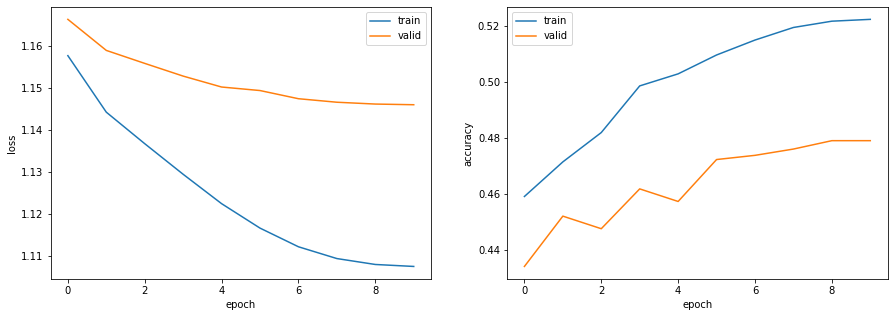

In [26]:
visualize_logs(log)

In [27]:
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'train：{acc_train:.3f}')
print(f'valid：{acc_test:.3f}')

train：0.522
valid：0.473


### 83 ミニバッチ化・GPU上での学習
>>
問題82のコードを改変し，BB事例ごとに損失・勾配を計算して学習を行えるようにせよ（BBの値は適当に選べ）．また，GPU上で学習を実行せよ

In [28]:
class Padsequence():
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx
  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])
    return {'inputs': sequences_padded, 'labels': labels}

In [29]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10
device = torch.device('cuda')

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE,device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch:1,loss_train: 1.2524, accuracy_train: 0.4003, loss_valid: 1.2609, accuracy_valid: 0.3861, 12.8522sec
epoch:2,loss_train: 1.2433, accuracy_train: 0.4208, loss_valid: 1.2640, accuracy_valid: 0.4025, 12.2500sec
epoch:3,loss_train: 1.1707, accuracy_train: 0.4966, loss_valid: 1.1998, accuracy_valid: 0.4685, 12.4299sec
epoch:4,loss_train: 1.0853, accuracy_train: 0.5740, loss_valid: 1.1407, accuracy_valid: 0.5487, 12.7245sec
epoch:5,loss_train: 1.0064, accuracy_train: 0.6344, loss_valid: 1.0666, accuracy_valid: 0.5960, 12.8701sec
epoch:6,loss_train: 0.9666, accuracy_train: 0.6571, loss_valid: 1.0579, accuracy_valid: 0.5982, 12.2530sec
epoch:7,loss_train: 0.8608, accuracy_train: 0.7188, loss_valid: 0.9421, accuracy_valid: 0.6694, 12.1858sec
epoch:8,loss_train: 0.8087, accuracy_train: 0.7435, loss_valid: 0.9068, accuracy_valid: 0.6859, 12.4051sec
epoch:9,loss_train: 0.8194, accuracy_train: 0.7290, loss_valid: 0.9345, accuracy_valid: 0.6597, 12.3782sec
epoch:10,loss_train: 0.7948, accuracy

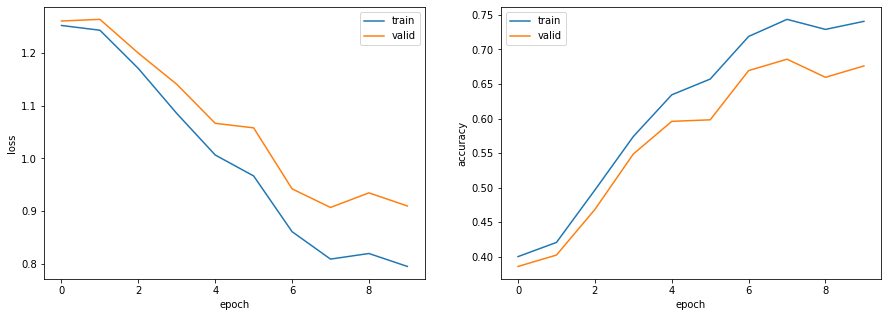

train：0.741
valid：0.700


In [30]:
visualize_logs(log)
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'train：{acc_train:.3f}')
print(f'valid：{acc_test:.3f}')

### 84 単語ベクトルの導入
>>
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込みemb(x)emb(x)を初期化し，学習せよ．

In [31]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-01-28 15:58:52--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.80.155
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.80.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  57.2MB/s    in 27s     

2022-01-28 15:59:19 (58.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [32]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'pretrained/vocabrary: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

pretrained/vocabrary: 9147 / 9378
torch.Size([9378, 300])


In [33]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False, device=None):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  
    if emb_weights != None:  
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
    self.device=device

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  
    emb = self.emb(x)
    out, hidden = self.rnn(emb, hidden)
    out = self.fc(out[:, -1, :])
    return out

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(self.device)
    return hidden

In [34]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10
device = torch.device('cuda')

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights,device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch:1,loss_train: 1.1871, accuracy_train: 0.4204, loss_valid: 1.2051, accuracy_valid: 0.4250, 13.5624sec
epoch:2,loss_train: 1.1149, accuracy_train: 0.5360, loss_valid: 1.1483, accuracy_valid: 0.5225, 12.8562sec
epoch:3,loss_train: 1.0372, accuracy_train: 0.6135, loss_valid: 1.0784, accuracy_valid: 0.5847, 12.8709sec
epoch:4,loss_train: 1.0755, accuracy_train: 0.5907, loss_valid: 1.1175, accuracy_valid: 0.5682, 12.8358sec
epoch:5,loss_train: 1.1650, accuracy_train: 0.5612, loss_valid: 1.2067, accuracy_valid: 0.5397, 12.8243sec


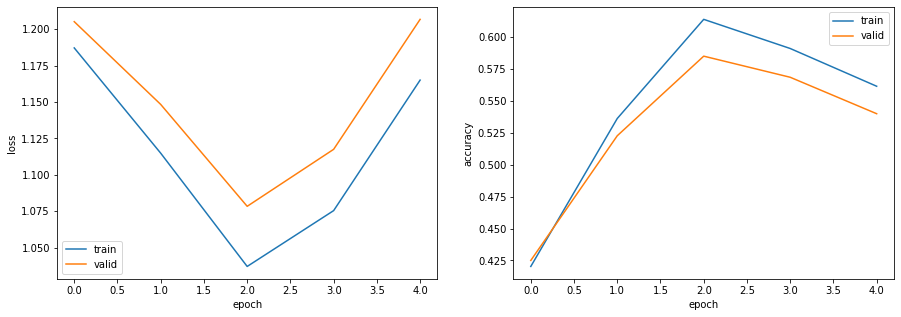

train acc：0.561
valid acc：0.555


In [36]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'train acc：{acc_train:.3f}')
print(f'valid acc：{acc_test:.3f}')

### 85 双方向RNN・多層化
>>
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

In [37]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10
device = torch.device('cuda')

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True, device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch:1,loss_train: 1.1421, accuracy_train: 0.4827, loss_valid: 1.1479, accuracy_valid: 0.4820, 26.8233sec
epoch:2,loss_train: 1.0972, accuracy_train: 0.5672, loss_valid: 1.1107, accuracy_valid: 0.5465, 26.8103sec
epoch:3,loss_train: 1.0304, accuracy_train: 0.6012, loss_valid: 1.0354, accuracy_valid: 0.5937, 26.8933sec
epoch:4,loss_train: 1.0466, accuracy_train: 0.5938, loss_valid: 1.0871, accuracy_valid: 0.5667, 27.0402sec
epoch:5,loss_train: 1.0117, accuracy_train: 0.6124, loss_valid: 1.0502, accuracy_valid: 0.5877, 26.8881sec
epoch:6,loss_train: 1.0178, accuracy_train: 0.6102, loss_valid: 1.0511, accuracy_valid: 0.5832, 26.9750sec
epoch:7,loss_train: 0.9960, accuracy_train: 0.6246, loss_valid: 1.0538, accuracy_valid: 0.5907, 26.9150sec


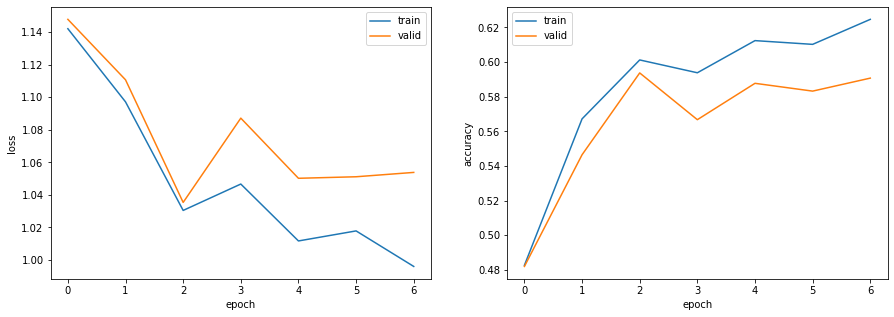

train acc：0.625
test acc：0.608


In [38]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'train acc：{acc_train:.3f}')
print(f'test acc：{acc_test:.3f}')

### 86 畳み込みニューラルネットワーク (CNN)
>>
ID番号で表現された単語列$x=(x1,x2,…,xT)$がある．ただし，$T$は単語列の長さ，$x_t∈ℝ^V$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\vec{x}$からカテゴリ$y$を予測するモデルを実装せよ．

In [39]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None: 
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    emb = self.emb(x).unsqueeze(1)
    conv = self.conv(emb)
    act = F.relu(conv.squeeze(3))
    max_pool = F.max_pool1d(act, act.size()[2])
    out = self.fc(self.drop(max_pool.squeeze(2)))
    return out

In [40]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2548, 0.2145, 0.2949, 0.2358]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2849, 0.2296, 0.2711, 0.2144]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2928, 0.2000, 0.2802, 0.2271]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3126, 0.2136, 0.2693, 0.2046]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2901, 0.2078, 0.2815, 0.2207]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2531, 0.2093, 0.3098, 0.2278]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2948, 0.1832, 0.3081, 0.2139]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2657, 0.2003, 0.3079, 0.2260]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2755, 0.1956, 0.2816, 0.2473]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2992, 0.2074, 0.2879, 0.2056]], grad_fn=<SoftmaxBackward0>)


### 87 確率的勾配降下法によるCNNの学習
>>
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [41]:
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
lr=5e-2
device=torch.device("cuda")
batch_size=64
epochs=10

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
log=train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs,collate_fn=Padsequence(PADDING_IDX),device=device)


epoch:1,loss_train: 1.3980, accuracy_train: 0.1273, loss_valid: 1.3914, accuracy_valid: 0.1619, 10.6656sec
epoch:2,loss_train: 1.3980, accuracy_train: 0.1273, loss_valid: 1.3914, accuracy_valid: 0.1619, 10.8270sec
epoch:3,loss_train: 1.3980, accuracy_train: 0.1273, loss_valid: 1.3914, accuracy_valid: 0.1619, 10.6979sec


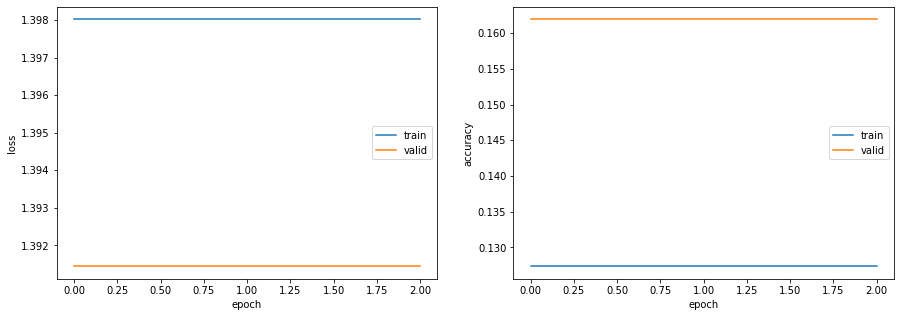

train acc：0.127
test acc0.156


In [42]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'train acc：{acc_train:.3f}')
print(f'test acc{acc_test:.3f}')

### 88 パラメータチューニング
>>
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [43]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params)*out_channels, output_size)

  def forward(self, x):
    emb = self.emb(x).unsqueeze(1)
    convs = [F.relu(conv(emb).squeeze(3)) for i, conv in enumerate(self.convs)]
    max_pools = [F.max_pool1d(conv, conv.size()[2]) for conv in convs]
    max_pool_cat=torch.cat(max_pools,1)
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    return out

In [44]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 42.5 MB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 112 kB 48.1 MB/s 
     |████████████████████████████████| 149 kB 48.1 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e78e485aaf54c2576160d3d03d8323056e8365ca11c45226410d0a538b0a38fa
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [45]:
import optuna

In [46]:
def objective(trial):
  emb_size=trial.suggest_discrete_uniform("emb_size",100,400,100)
  out_channels=trial.suggest_discrete_uniform("out_channels",50,200,50)
  drop_rate=trial.suggest_discrete_uniform("drop_rate",0.0,0.5,0.1)
  lr=trial.suggest_loguniform("lr",5e-4,5e-2)
  momentum=trial.suggest_discrete_uniform("momentum",0.5,0.9,0.1)
  batch_size=int(trial.suggest_discrete_uniform("batch_size",16,64,16))

  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  cnv_params=[[2, 0], [3, 1], [4, 2]]
  device=torch.device("cuda")
  epochs=10

  criterion=nn.CrossEntropyLoss()
  model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, cnv_params, drop_rate,emb_weights=weights)
  optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  log=train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs,collate_fn=Padsequence(PADDING_IDX),device=device)
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device)
  return loss_valid

In [47]:
study=optuna.create_study()
study.optimize(objective,timeout=10)
trial=study.best_trial
print("best trial:")
print(f"value:{trial.value}")
print("params")
for key,value in trial.params.items():
  print(f"{key}:{value}")

[I 2022-01-28 16:27:10,222] A new study created in memory with name: no-name-78489007-d1cd-428f-a133-7dc95265eb1a


epoch:1,loss_train: 1.1287, accuracy_train: 0.5034, loss_valid: 1.1284, accuracy_valid: 0.5150, 33.3158sec
epoch:2,loss_train: 1.0959, accuracy_train: 0.5185, loss_valid: 1.0951, accuracy_valid: 0.5412, 23.0918sec
epoch:3,loss_train: 1.0637, accuracy_train: 0.6042, loss_valid: 1.0734, accuracy_valid: 0.5712, 23.1293sec
epoch:4,loss_train: 1.0339, accuracy_train: 0.6185, loss_valid: 1.0456, accuracy_valid: 0.5937, 23.2241sec
epoch:5,loss_train: 1.0093, accuracy_train: 0.6345, loss_valid: 1.0262, accuracy_valid: 0.6087, 23.1969sec
epoch:6,loss_train: 0.9894, accuracy_train: 0.6436, loss_valid: 1.0107, accuracy_valid: 0.6049, 24.3630sec
epoch:7,loss_train: 0.9753, accuracy_train: 0.6505, loss_valid: 1.0010, accuracy_valid: 0.6162, 23.1465sec
epoch:8,loss_train: 0.9667, accuracy_train: 0.6552, loss_valid: 0.9949, accuracy_valid: 0.6229, 23.1596sec
epoch:9,loss_train: 0.9627, accuracy_train: 0.6580, loss_valid: 0.9914, accuracy_valid: 0.6259, 23.1742sec
epoch:10,loss_train: 0.9616, accuracy

[I 2022-01-28 16:31:15,354] Trial 0 finished with value: 0.0 and parameters: {'emb_size': 100.0, 'out_channels': 100.0, 'drop_rate': 0.0, 'lr': 0.004588504456773776, 'momentum': 0.7, 'batch_size': 48.0}. Best is trial 0 with value: 0.0.


best trial:
value:0.0
params
emb_size:100.0
out_channels:100.0
drop_rate:0.0
lr:0.004588504456773776
momentum:0.7
batch_size:48.0


In [48]:
emb_size=int(trial.params["emb_size"])
out_channels=int(trial.params["out_channels"])
drop_rate=trial.params["drop_rate"]
lr=trial.params["lr"]
momentum=trial.params["momentum"]
batch_size=int(trial.params["batch_size"])

VOCAB_SIZE = len(set(word2id.values())) + 1
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
cnv_params=[[2, 0], [3, 1], [4, 2]]
device=torch.device("cuda")
epochs=10

criterion=nn.CrossEntropyLoss()
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, cnv_params, drop_rate,emb_weights=weights)
optimizer=torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)
log=train_model(dataset_train,dataset_valid,batch_size,model,criterion,optimizer,epochs,collate_fn=Padsequence(PADDING_IDX),device=device)

epoch:1,loss_train: 1.1297, accuracy_train: 0.4881, loss_valid: 1.1257, accuracy_valid: 0.5187, 23.3170sec
epoch:2,loss_train: 1.0978, accuracy_train: 0.5456, loss_valid: 1.0998, accuracy_valid: 0.5465, 23.2706sec
epoch:3,loss_train: 1.0699, accuracy_train: 0.5936, loss_valid: 1.0814, accuracy_valid: 0.5682, 23.1435sec
epoch:4,loss_train: 1.0408, accuracy_train: 0.6088, loss_valid: 1.0533, accuracy_valid: 0.5817, 23.3053sec
epoch:5,loss_train: 1.0174, accuracy_train: 0.6197, loss_valid: 1.0375, accuracy_valid: 0.5952, 23.3082sec
epoch:6,loss_train: 0.9980, accuracy_train: 0.6356, loss_valid: 1.0193, accuracy_valid: 0.6132, 23.2329sec
epoch:7,loss_train: 0.9842, accuracy_train: 0.6402, loss_valid: 1.0092, accuracy_valid: 0.6169, 23.1661sec
epoch:8,loss_train: 0.9759, accuracy_train: 0.6431, loss_valid: 1.0030, accuracy_valid: 0.6162, 23.3143sec
epoch:9,loss_train: 0.9720, accuracy_train: 0.6466, loss_valid: 0.9998, accuracy_valid: 0.6162, 23.2078sec
epoch:10,loss_train: 0.9709, accuracy

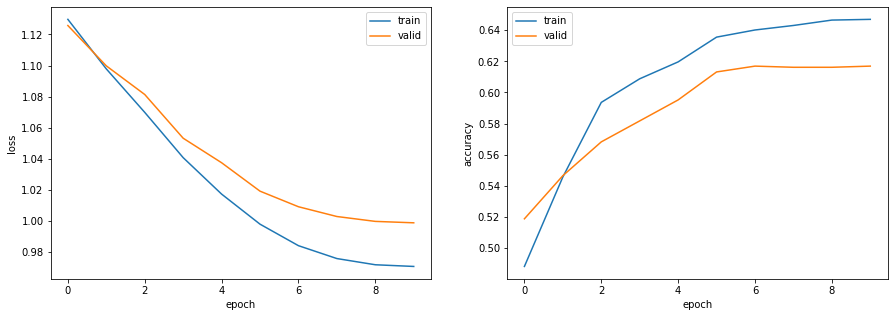

正解率（学習データ）：0.647
正解率（評価データ）：0.626


In [49]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')